<a href="https://colab.research.google.com/github/Samjacob007/image-segmentation/blob/main/Image_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libaries

In [1]:
# Importing relevant modules.
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO  # API for COCO dataset.
import skimage.io as io
import json
import pandas as pd
import seaborn as sns
from collections import defaultdict
import random
import matplotlib.patches as mpatches
from PIL import Image
from matplotlib.colors import ListedColormap
%matplotlib inline

#mount drive

In [2]:
# Import and mount Google Drive.

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Unzip the dataset file and store it in a folder called images.

!unzip -o "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/coco2017/"

Archive:  /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001459.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/00000000141

In [4]:
# Define paths
train_annotation_file = "/content/drive/MyDrive/coco2017/train-300/labels.json"
val_annotation_file = "/content/drive/MyDrive/coco2017/validation-300/labels.json"

# Load annotation JSONs
with open(train_annotation_file) as f:
    train_data = json.load(f)

with open(val_annotation_file) as f:
    val_data = json.load(f)


In [6]:
# Use COCO API to get category mapping
# Create a COCO object to load and parse the annotation file
coco = COCO(train_annotation_file)

category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)
category_id_to_name = {cat["id"]: cat["name"] for cat in categories}
# Define target_classes before using it
target_classes = ["cake", "car", "dog", "person"]
target_ids = [cat["id"] for cat in categories if cat["name"] in target_classes]

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [7]:
# Extract and display COCO categories and supercategories for the training dataset.

category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)

print(categories)

names_cats = [cats["name"] for cats in categories]
print(len(names_cats), "COCO categories:", " ".join(names_cats))

names_scats = set([cats["supercategory"] for cats in categories])
print(len(names_scats), "COCO supercategories:", " ".join(names_scats))

[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}, {'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}, {'id': 2, 'name': 'banana', 'supercategory': 'food'}, {'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}, {'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}, {'id': 5, 'name': 'bear', 'supercategory': 'animal'}, {'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}, {'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}, {'id': 8, 'name': 'bird', 'supercategory': 'animal'}, {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}, {'id': 10, 'name': 'book', 'supercategory': 'indoor'}, {'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}, {'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}, {'id': 13, 'name': 'broccoli', 'supercategory': 'food'}, {'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}, {'id': 15, 'name': 'cake', 'supercategory': 'food'}, {'id': 16, 'name': 'car', 'supercategory': 'vehicle'}, {'id': 17, 'name': 'carrot', 'sup

In [8]:
# Define function to extract category name from ID.

def get_category_name(class_ID, categories):
    for i in range(len(categories)):
        if categories[i]["id"] == class_ID:
            return categories[i]["name"]
    return "None"

In [10]:
# Get all training images containing a given object category or categories.
# Remember, for this assignment we will focus on the classes "person", "cake", "dog", "car"!

filter_class = ["cat"]
category_IDs = coco.getCatIds(catNms=filter_class)
image_IDs = coco.getImgIds(catIds=category_IDs)

print(f"Number of images containing specified category(ies): {len(image_IDs)}.")
print(f"IDs of images containing specified category(ies): {image_IDs}.")

# What happens when you are filtering for a different category or multiple classes?

Number of images containing specified category(ies): 4.
IDs of images containing specified category(ies): [299, 132, 268, 294].


{'id': 299, 'file_name': '000000003935.jpg', 'height': 554, 'width': 640, 'license': None, 'coco_url': None}


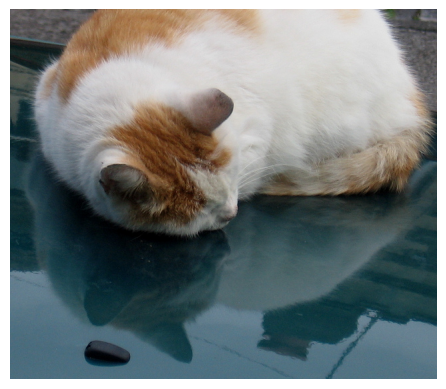

In [12]:
# Load and display one of the example images.

example_image = coco.loadImgs(image_IDs[0])[0]
print(example_image)

# Define the path to the training data images
train_data_path = "/content/drive/MyDrive/coco2017/train-300"

image = io.imread(f'{train_data_path}/data/{example_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

plt.show()

In [13]:
# Get COCO annotation IDs and content of annotations, i.e., bounding boxes and segmentation masks.

test_image_annotations_ID = coco.getAnnIds(
    imgIds=example_image["id"], catIds=category_IDs, iscrowd=None
)
print(test_image_annotations_ID)

test_image_annotations = coco.loadAnns(test_image_annotations_ID)
print(test_image_annotations)

# Make sure you understand the content of the annotations.

[3840]
[{'id': 3840, 'image_id': 299, 'category_id': 18, 'bbox': [33.36, 0.83, 602.85, 338.35], 'segmentation': [[266.0, 338.5, 225.0, 337.5, 158.0, 319.5, 156.0, 313.5, 139.0, 308.5, 121.0, 296.5, 111.0, 276.5, 66.5, 247.0, 51.5, 220.0, 47.5, 182.0, 32.5, 148.0, 44.5, 96.0, 67.0, 75.5, 72.5, 87.0, 88.5, 43.0, 139.0, 0, 554.0, 1.5, 601.5, 116.0, 635.5, 163.0, 611.5, 217.0, 589.5, 250.0, 554.0, 264.5, 466.0, 277.5, 346.0, 280.5, 335.5, 284.0, 346.0, 303.5, 331.0, 309.5, 316.0, 324.5, 287.0, 328.5, 266.0, 338.5]], 'area': 203974.29750000002, 'iscrowd': 0, 'supercategory': 'animal'}]


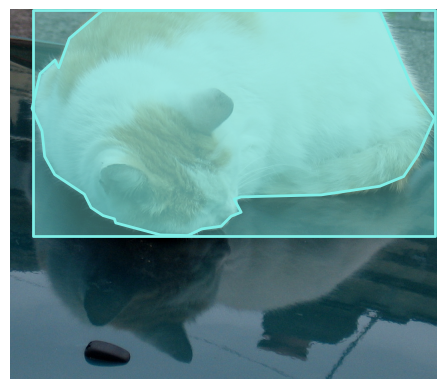

In [14]:
# Load and display test image with instance annotations.

plt.imshow(image)
plt.axis("off")

coco.showAnns(test_image_annotations, draw_bbox=True)

# Try to remove the bounding box from the image and show the segmentation ground truth only.

In [15]:
# Extract the training images that contain any combination of the four target classes.

target_classes = ["cake", "car", "dog", "person"]
target_classes_IDs = coco.getCatIds(catNms=target_classes)
training_images = []

# Iterate over each individual class in the list.
for class_name in target_classes:
    # Get all images containing target class.
    print(class_name)
    training_images_categories = coco.getCatIds(catNms=class_name)
    training_images_IDs = coco.getImgIds(catIds=training_images_categories)
    training_images += coco.loadImgs(training_images_IDs)

print(
    f"Number of images with target classes including repetitions: {len(training_images)}."
)

cake
car
dog
person
Number of images with target classes including repetitions: 566.


In [16]:
# Filter out repeated images.

unique_training_images = []

for i in range(len(training_images)):
    if training_images[i] not in unique_training_images:
        unique_training_images.append(training_images[i])

# Shuffle the training data.
random.seed(0)
random.shuffle(unique_training_images)

print(
    f"Number of unique images in training data containing the target classes: {len(unique_training_images)}"
)


Number of unique images in training data containing the target classes: 300


{'id': 101, 'file_name': '000000007201.jpg', 'height': 427, 'width': 640, 'license': None, 'coco_url': None}


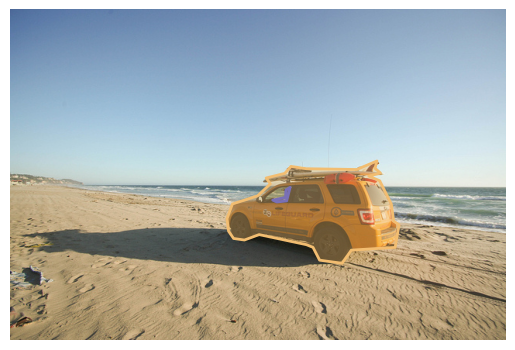

In [17]:
# Load and display example training image with segmentation masks.

training_image = unique_training_images[10]
print(training_image)

image = io.imread(f'{train_data_path}/data/{training_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

training_image_annotations_ID = coco.getAnnIds(
    imgIds=training_image["id"], catIds=target_classes_IDs, iscrowd=None
)
training_image_annotations = coco.loadAnns(training_image_annotations_ID)
coco.showAnns(training_image_annotations, draw_bbox=False)

plt.show()

In [18]:
# To generate segmentation mask use annToMask function and extract the info stored in the annotations.
# For example, for the first object in our example training image:

mask_example = coco.annToMask(training_image_annotations[0])

print(type(mask_example))
print(mask_example)
print(mask_example.shape)
print(np.max(mask_example))
print(np.min(mask_example))

<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(427, 640)
1
0


Unique pixel values in the mask: [0. 3.]


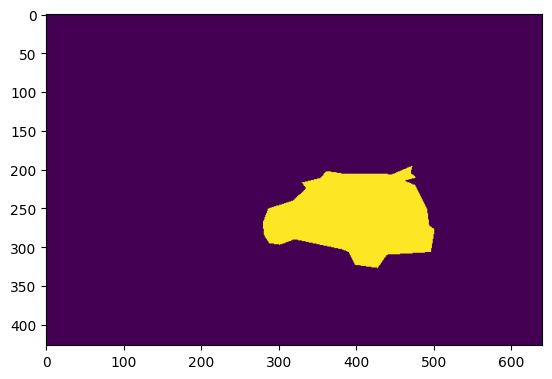

In [19]:
# Plotting the segmentation masks with different colours.
# There are many ways to do this. This is just one example.

mask = np.zeros((training_image["height"], training_image["width"]))

for i in range(len(training_image_annotations)):
    # Get object category name.
    object_category = get_category_name(
        training_image_annotations[i]["category_id"], categories
    )
    # Assign pixel value based on location in target_classes list.
    pixel_value = target_classes.index(object_category) + 1
    # Assign pixel value to mask based on annToMask output.
    mask = np.maximum(coco.annToMask(training_image_annotations[i]) * 3, mask)

print(f"Unique pixel values in the mask: {np.unique(mask)}")

plt.imshow(mask)
plt.show()

#Exploratory data analysis

##CLASS DISTRIBUTION

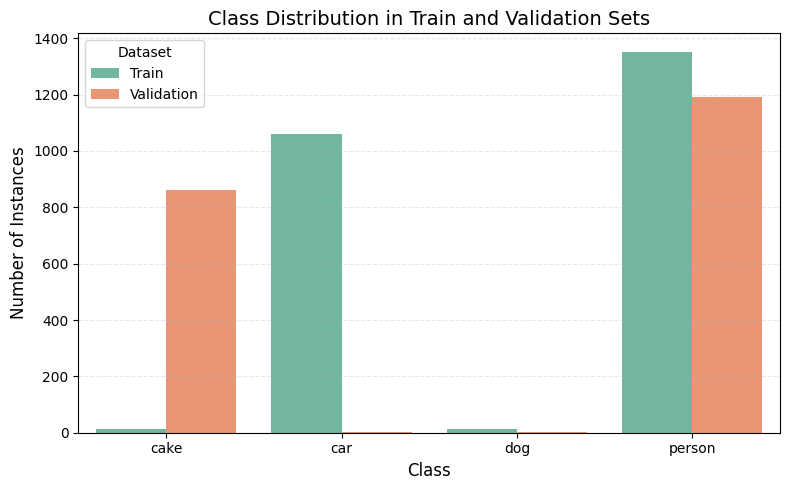

In [20]:
# Function to extract class counts
def get_class_distribution(data, label="dataset"):
    rows = []
    for ann in data['annotations']:
        cat_id = ann['category_id']
        if cat_id in target_ids:
            class_name = category_id_to_name[cat_id]
            rows.append({'Class': class_name, 'Dataset': label})
    return pd.DataFrame(rows)

# Generate DataFrames
train_df = get_class_distribution(train_data, label="Train")
val_df = get_class_distribution(val_data, label="Validation")
combined_df = pd.concat([train_df, val_df])

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=combined_df, x='Class', hue='Dataset', palette='Set2', order=target_classes)
plt.title("Class Distribution in Train and Validation Sets", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Instances", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


##image size analysis


=== IMAGE SIZE ANALYSIS ===


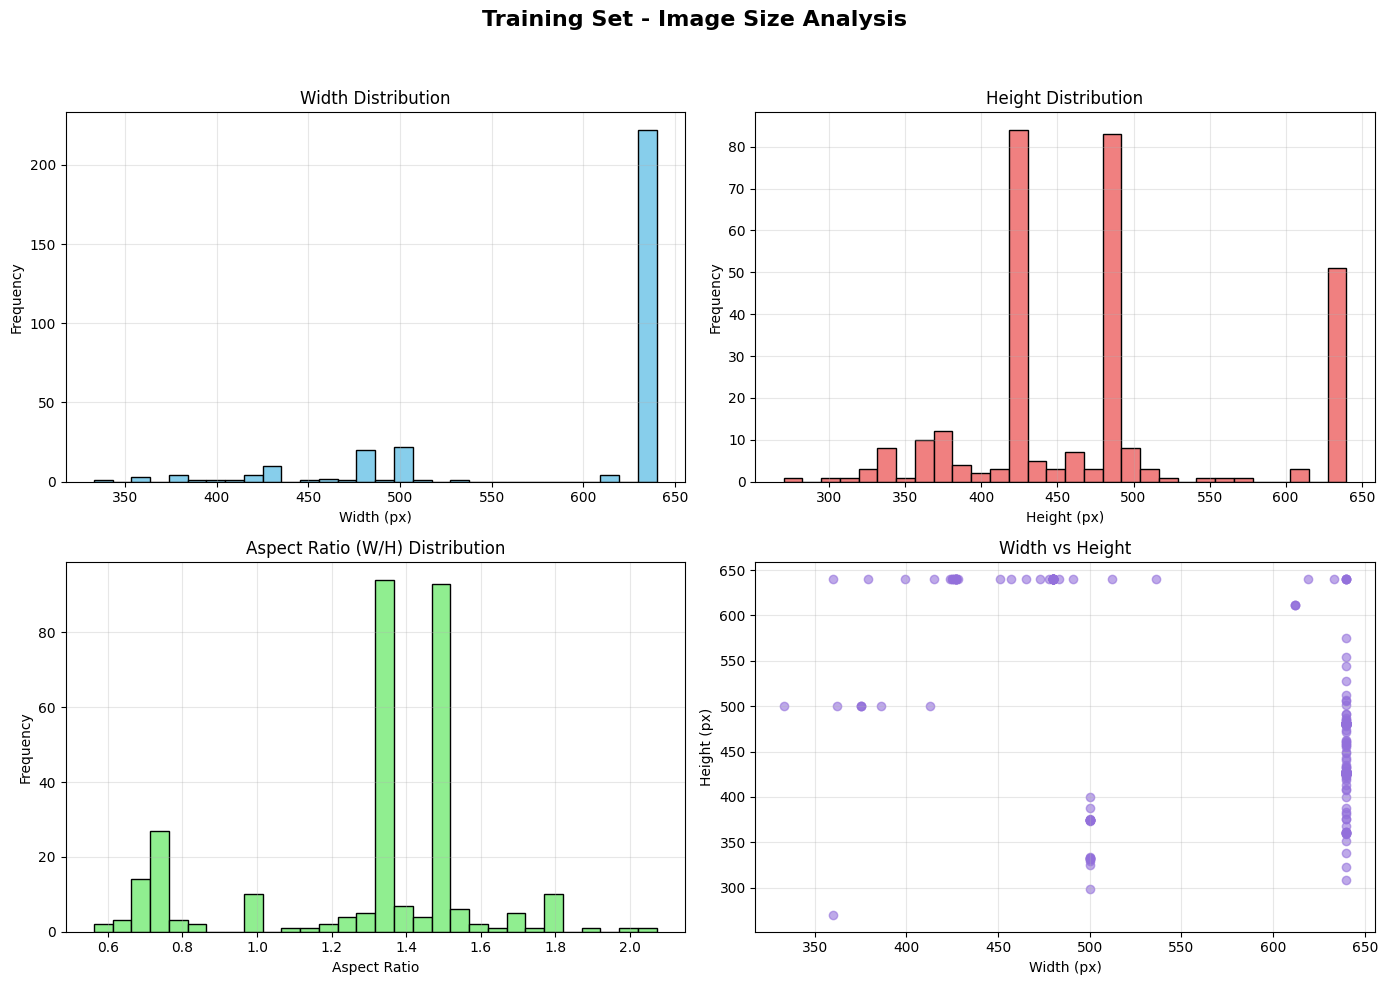

Average width       : 595.30 px
Average height      : 475.40 px
Average aspect ratio: 1.30 (W/H)
Min width/height    : 333/270 px
Max width/height    : 640/640 px
----------------------------------------


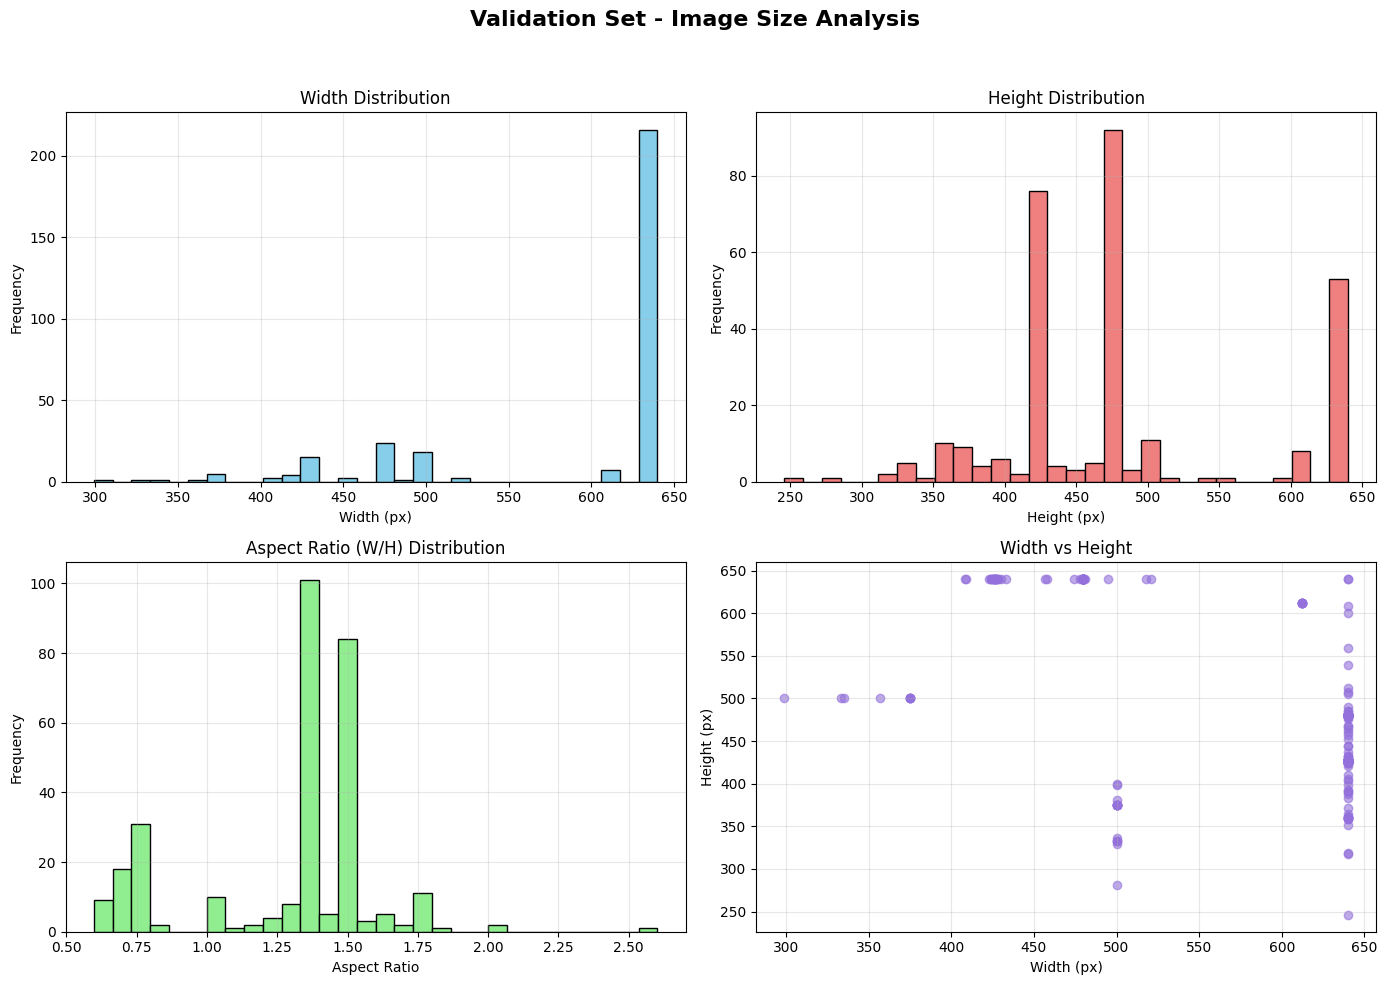

Average width       : 591.95 px
Average height      : 482.85 px
Average aspect ratio: 1.28 (W/H)
Min width/height    : 299/246 px
Max width/height    : 640/640 px
----------------------------------------


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def get_image_dimensions(data):

    widths = [img['width'] for img in data['images']]
    heights = [img['height'] for img in data['images']]
    aspect_ratios = [w / h for w, h in zip(widths, heights)]
    return widths, heights, aspect_ratios

def plot_image_size_distribution(widths, heights, aspect_ratios, title):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Width histogram
    axes[0, 0].hist(widths, bins=30, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Width Distribution')
    axes[0, 0].set_xlabel('Width (px)')
    axes[0, 0].set_ylabel('Frequency')

    # Height histogram
    axes[0, 1].hist(heights, bins=30, color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Height Distribution')
    axes[0, 1].set_xlabel('Height (px)')
    axes[0, 1].set_ylabel('Frequency')

    # Aspect Ratio histogram
    axes[1, 0].hist(aspect_ratios, bins=30, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Aspect Ratio (W/H) Distribution')
    axes[1, 0].set_xlabel('Aspect Ratio')
    axes[1, 0].set_ylabel('Frequency')

    # Scatter plot of width vs height
    axes[1, 1].scatter(widths, heights, alpha=0.6, color='mediumpurple')
    axes[1, 1].set_title('Width vs Height')
    axes[1, 1].set_xlabel('Width (px)')
    axes[1, 1].set_ylabel('Height (px)')

    # Grid & layout
    for ax in axes.flat:
        ax.grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def summarize_image_sizes(widths, heights, aspect_ratios):
    """Print basic statistics about image dimensions."""
    print(f"Average width       : {np.mean(widths):.2f} px")
    print(f"Average height      : {np.mean(heights):.2f} px")
    print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f} (W/H)")
    print(f"Min width/height    : {min(widths)}/{min(heights)} px")
    print(f"Max width/height    : {max(widths)}/{max(heights)} px")
    print("-" * 40)

def analyze_image_sizes(data, title="Image Size Analysis"):
    """Combined function to analyze and visualize image sizes."""
    widths, heights, aspect_ratios = get_image_dimensions(data)
    plot_image_size_distribution(widths, heights, aspect_ratios, title)
    summarize_image_sizes(widths, heights, aspect_ratios)

# Run for both datasets
print("\n=== IMAGE SIZE ANALYSIS ===")
analyze_image_sizes(train_data, "Training Set - Image Size Analysis")
analyze_image_sizes(val_data, "Validation Set - Image Size Analysis")

##Segmentation Area Distribution


=== SEGMENTATION AREA DISTRIBUTION ===


/tmp/ipython-input-22-1752602531.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(areas_by_class.values(), labels=areas_by_class.keys(), showfliers=False)


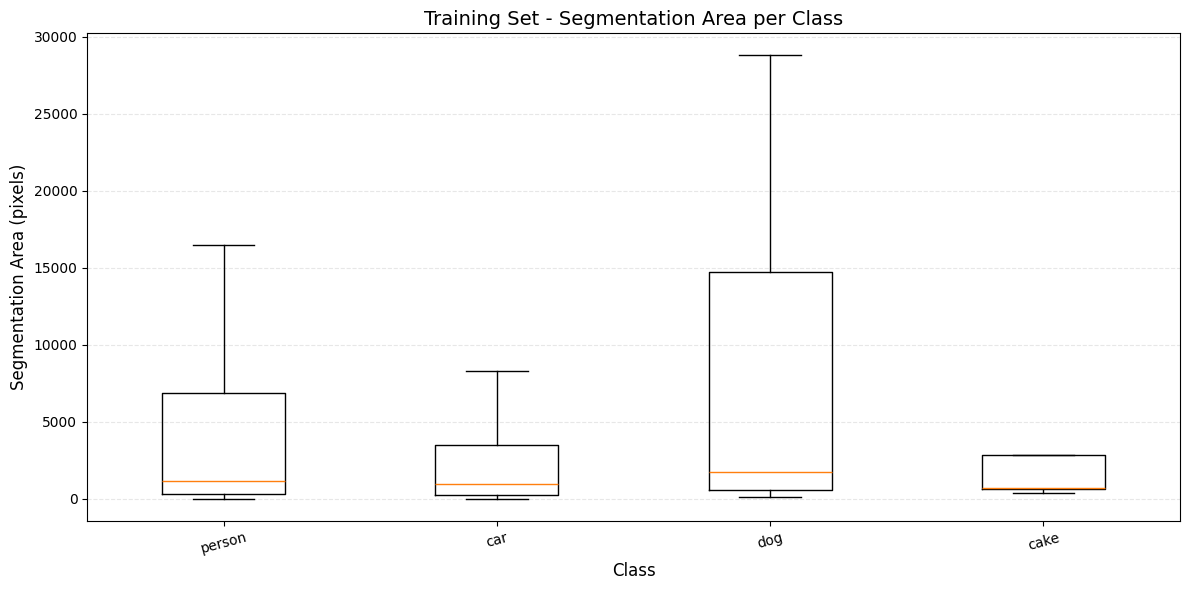

In [22]:
def plot_segmentation_area_distribution(data, title="Segmentation Area Distribution", target_ids=None, category_id_to_name=None):
    areas_by_class = defaultdict(list)

    for ann in data['annotations']:
        cat_id = ann['category_id']
        if target_ids and cat_id not in target_ids:
            continue  # Skip non-target categories
        class_name = category_id_to_name[cat_id] if category_id_to_name else str(cat_id)
        areas_by_class[class_name].append(ann['area'])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.boxplot(areas_by_class.values(), labels=areas_by_class.keys(), showfliers=False)
    plt.title(title, fontsize=14)
    plt.ylabel("Segmentation Area (pixels)", fontsize=12)
    plt.xlabel("Class", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
    # Reuse category_id_to_name and target_ids from earlier
target_classes = ["car", "dog", "person", "cake"]
category_IDs = coco.getCatIds(catNms=target_classes)
category_id_to_name = {cat["id"]: cat["name"] for cat in coco.loadCats(category_IDs)}

# Call function
print("\n=== SEGMENTATION AREA DISTRIBUTION ===")
plot_segmentation_area_distribution(train_data, "Training Set - Segmentation Area per Class", category_IDs, category_id_to_name)


##Segmented Objects per Image


=== SEGMENTED OBJECTS PER IMAGE ===


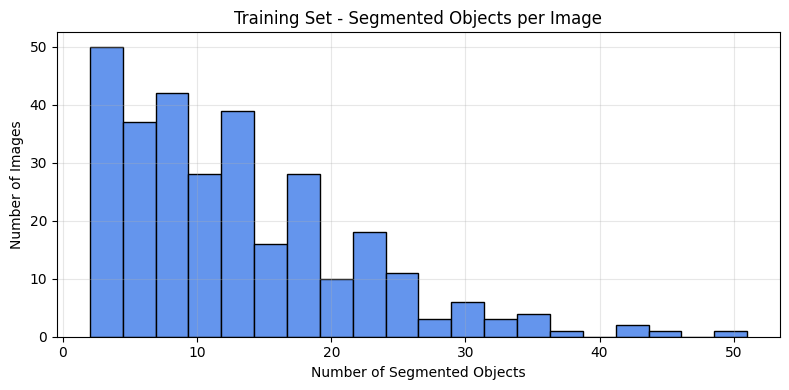

Average segments per image: 12.90
Max segments in one image: 51
Min segments in one image: 2


In [23]:
def plot_segmented_objects_per_image(data, title="Segmented Objects per Image"):
    from collections import Counter

    count_per_image = Counter([ann['image_id'] for ann in data['annotations']])
    counts = list(count_per_image.values())

    plt.figure(figsize=(8, 4))
    plt.hist(counts, bins=20, color='cornflowerblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Number of Segmented Objects")
    plt.ylabel("Number of Images")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Average segments per image: {np.mean(counts):.2f}")
    print(f"Max segments in one image: {np.max(counts)}")
    print(f"Min segments in one image: {np.min(counts)}")

print("\n=== SEGMENTED OBJECTS PER IMAGE ===")
plot_segmented_objects_per_image(train_data, "Training Set - Segmented Objects per Image")

##SAMPLE MASK VISUALIZATION

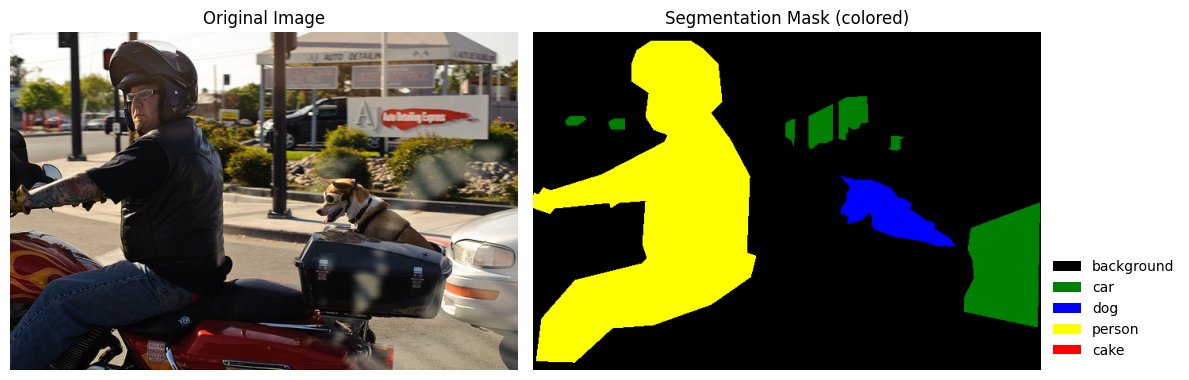


=== SAMPLE MASK VISUALIZATION (COLORED) ===


In [28]:
# Define your target classes
target_classes = ["car", "dog", "person", "cake"]

# Get their COCO category IDs
category_IDs = coco.getCatIds(catNms=target_classes)
categories = coco.loadCats(category_IDs)

# Create a name-to-ID mapping
target_class_ids = {cat["name"]: cat["id"] for cat in categories}

def show_sample_masks_colored(data, class_name='person', num_samples=1, image_root_path=None):
    target_id = target_class_ids[class_name]

    # Filter annotations for the selected class
    anns = [ann for ann in data['annotations'] if ann['category_id'] == target_id]

    for ann in anns[:num_samples]:
        img_info = next(img for img in data['images'] if img['id'] == ann['image_id'])
        img_path = os.path.join(image_root_path, 'data', img_info['file_name'])

        img = np.array(Image.open(img_path).convert("RGB"))

        # Get all annotations for that image (only for your 4 target classes)
        image_anns = [a for a in data['annotations']
                      if a['image_id'] == img_info['id'] and a['category_id'] in target_class_ids.values()]

        # Create colored mask
        mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
        for a in image_anns:
            class_name = [name for name, cid in target_class_ids.items() if cid == a["category_id"]][0]
            pixel_value = target_classes.index(class_name) + 1
            mask = np.maximum(coco.annToMask(a) * pixel_value, mask)

        # Define a colormap: 0=background, then colors for each class
        color_map = ListedColormap(['black', 'green', 'blue', 'yellow', 'red'])  # Adjust as you like
        class_labels = ['background'] + target_classes

        # Plot image and colored mask
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(img)
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        im = axs[1].imshow(mask, cmap=color_map, vmin=0, vmax=len(target_classes))
        axs[1].set_title("Segmentation Mask (colored)")
        axs[1].axis("off")

        # Optional: legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=color_map(i), label=label) for i, label in enumerate(class_labels)]
        axs[1].legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0), frameon=False)

        plt.tight_layout()
        plt.show()
        print("\n=== SAMPLE MASK VISUALIZATION (COLORED) ===")
show_sample_masks_colored(train_data, class_name='dog', num_samples=1, image_root_path=train_data_path)



##COCOTargetSegmentationDataset

In [29]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io

class COCOSegmentationDataset(Dataset):
    def __init__(self, image_dir, annotation_file, target_classes, image_size=(128, 128)):

        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_size = image_size
        self.target_classes = target_classes
        self.cat_ids = self.coco.getCatIds(catNms=target_classes)

        # Get unique image IDs containing any of the target classes
        image_ids = []
        for cat_id in self.cat_ids:
            image_ids += self.coco.getImgIds(catIds=cat_id)
        self.image_ids = list(set(image_ids))

        # Mapping category id to target index (1 to 4)
        self.class_map = {cat_id: idx + 1 for idx, cat_id in enumerate(self.cat_ids)}

        # Define image transforms
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0,1] and CHW format
            transforms.Resize(self.image_size)
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info["file_name"])

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.image_transform(image)

        # Create blank mask
        mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)

        # Load annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            cat_id = ann["category_id"]
            if cat_id in self.class_map:
                class_idx = self.class_map[cat_id]
                ann_mask = self.coco.annToMask(ann)
                mask = np.where(ann_mask == 1, class_idx, mask)

        # Resize mask
        mask = Image.fromarray(mask)
        mask = mask.resize(self.image_size, resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()  # (H, W) class indices

        return image, mask


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


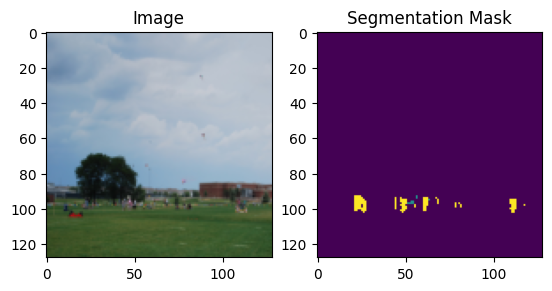

In [30]:
# Define paths
image_dir = "/content/drive/MyDrive/coco2017/train-300/data"
annotation_file = "/content/drive/MyDrive/coco2017/train-300/labels.json"
target_classes = ["cake", "car", "dog", "person"]

# Create dataset
train_dataset = COCOSegmentationDataset(
    image_dir=image_dir,
    annotation_file=annotation_file,
    target_classes=target_classes,
    image_size=(128, 128)
)

# Example: show one image and mask
import matplotlib.pyplot as plt

img, mask = train_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Segmentation Mask")
plt.show()


#U Net model

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=5):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)


In [32]:
import torch
torch.cuda.empty_cache()


In [33]:
import torch.optim as optim

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=5).to(device)

weights = torch.tensor([0.2, 1.0, 0.5, 1.0, 1.0], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)


optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [34]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)



##Model Training

In [35]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/20], Loss: 161.5286
Epoch [2/20], Loss: 129.6054
Epoch [3/20], Loss: 127.3892
Epoch [4/20], Loss: 124.5049
Epoch [5/20], Loss: 121.3496
Epoch [6/20], Loss: 121.3253
Epoch [7/20], Loss: 117.8350
Epoch [8/20], Loss: 116.0725
Epoch [9/20], Loss: 113.8188
Epoch [10/20], Loss: 112.0814
Epoch [11/20], Loss: 111.2227
Epoch [12/20], Loss: 113.2144
Epoch [13/20], Loss: 109.6286
Epoch [14/20], Loss: 109.1787
Epoch [15/20], Loss: 107.3223
Epoch [16/20], Loss: 108.3130
Epoch [17/20], Loss: 106.3755
Epoch [18/20], Loss: 108.6161
Epoch [19/20], Loss: 106.1035
Epoch [20/20], Loss: 105.1652


In [36]:
torch.save(model.state_dict(), "/content/drive/MyDrive/unet_coco_segmentation.pth")


In [38]:
# Load the saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/unet_coco_segmentation.pth", map_location='cpu'))


<All keys matched successfully>

In [39]:
def pixel_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

def compute_iou(preds, labels, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().float()
        union = (pred_inds | label_inds).sum().float()
        if union == 0:
            ious.append(torch.tensor(float('nan')))
        else:
            ious.append(intersection / union)
    return ious


In [40]:
pred = torch.argmax(outputs[0], dim=0).cpu().numpy()
print("Unique predicted class indices:", np.unique(pred))

Unique predicted class indices: [0 4]


##Visualize U-Net Predictions on Training Images

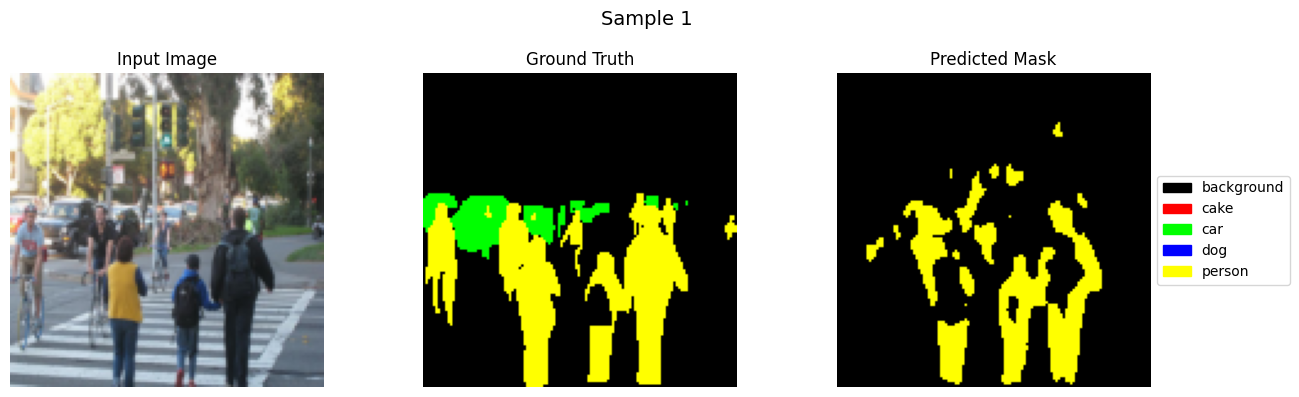

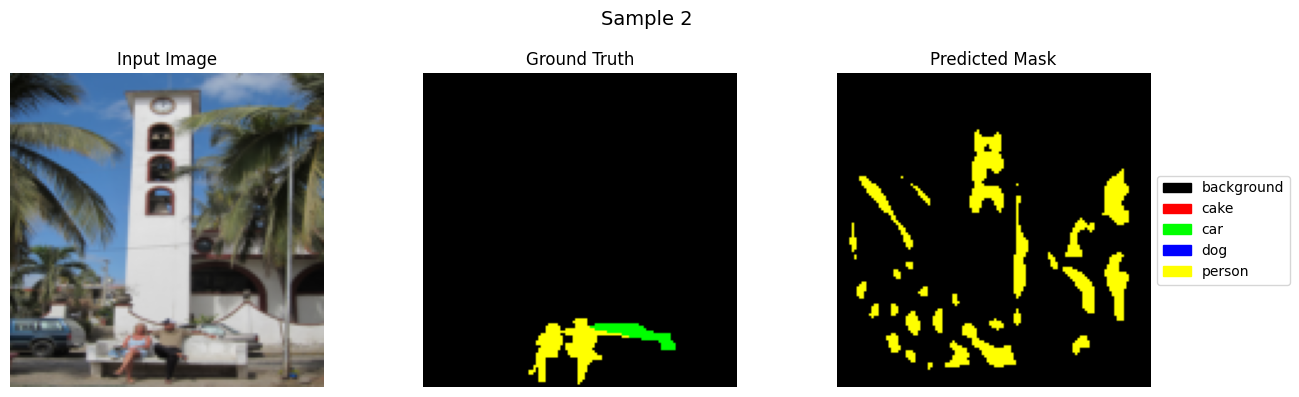

In [41]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

# Define class names and colors
class_names = ['background', 'cake', 'car', 'dog', 'person']
class_colors = {
    0: (0, 0, 0),        # Black for background
    1: (255, 0, 0),      # Red for cake
    2: (0, 255, 0),      # Green for car
    3: (0, 0, 255),      # Blue for dog
    4: (255, 255, 0)     # Yellow for person
}

def apply_color_mask(mask):
    """Apply RGB color to each class index in the mask"""
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask

def visualize_prediction(image, mask, pred, index=0):
    image = image.cpu().permute(1, 2, 0).numpy()
    mask = mask.cpu().numpy()
    pred = torch.argmax(pred, dim=0).cpu().numpy()

    mask_color = apply_color_mask(mask)
    pred_color = apply_color_mask(pred)

    plt.figure(figsize=(14, 4))
    plt.suptitle(f"Sample {index+1}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_color)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")
    plt.axis("off")

    # Add legend
    legend_patches = [mpatches.Patch(color=np.array(color)/255.0, label=label)
                      for label, color in zip(class_names, class_colors.values())]
    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

# Run model on 2 random images that contain at least some mask
model.eval()
shown = 0
attempts = 0

while shown < 2 and attempts < 100:
    idx = random.randint(0, len(train_dataset) - 1)
    img, mask = train_dataset[idx]
    if mask.sum() > 50:  # ensures non-empty mask
        with torch.no_grad():
            img_input = img.unsqueeze(0).to(device)
            output = model(img_input)
            visualize_prediction(img, mask, output[0], index=shown)
        shown += 1
    attempts += 1



##Evaluate U-Net on Training Set: Pixel Accuracy & Class-wise IoU

In [42]:
import torch
import numpy as np

def pixel_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

def compute_iou(preds, labels, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().float()
        union = (pred_inds | label_inds).sum().float()
        if union == 0:
            ious.append(torch.tensor(float('nan')))
        else:
            ious.append(intersection / union)
    return ious


In [43]:
model.eval()
shown = 0
attempts = 0

while shown < 3 and attempts < 100:
    idx = random.randint(0, len(train_dataset) - 1)
    img, mask = train_dataset[idx]
    if mask.sum() > 50:
        with torch.no_grad():
            input_tensor = img.unsqueeze(0).to(device)
            output = model(input_tensor)

            acc = pixel_accuracy(output, mask.unsqueeze(0).to(device))
            iou = compute_iou(output, mask.unsqueeze(0).to(device))

            print(f"\n🖼️ Sample {idx}:")
            print(f"Pixel-wise Accuracy: {acc:.4f}")
            print("Class-wise IoU:")
            for i, val in enumerate(iou):
                val_str = f"{val.item():.4f}" if not torch.isnan(val) else "N/A"
                print(f"  Class {i}: {val_str}")

        shown += 1
    attempts += 1



🖼️ Sample 143:
Pixel-wise Accuracy: 0.9534
Class-wise IoU:
  Class 0: 0.9528
  Class 1: N/A
  Class 2: 0.0000
  Class 3: N/A
  Class 4: 0.3232

🖼️ Sample 93:
Pixel-wise Accuracy: 0.9113
Class-wise IoU:
  Class 0: 0.9080
  Class 1: N/A
  Class 2: 0.0000
  Class 3: N/A
  Class 4: 0.2905

🖼️ Sample 51:
Pixel-wise Accuracy: 0.7794
Class-wise IoU:
  Class 0: 0.7855
  Class 1: N/A
  Class 2: 0.0000
  Class 3: N/A
  Class 4: 0.3421


##Visualize U-Net Predictions on Validation Images

In [50]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Class info
class_names = ['background', 'cake', 'car', 'dog', 'person']
class_colors = {
    0: (0, 0, 0),
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0, 0, 255),
    4: (255, 255, 0),
}

# Color mask converter
def apply_color_mask(mask):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask

# Visualization function
def visualize_prediction(image, mask, pred, index=0):
    image = image.cpu().permute(1, 2, 0).numpy()
    mask = mask.cpu().numpy()
    pred = torch.argmax(pred, dim=0).cpu().numpy()

    mask_color = apply_color_mask(mask)
    pred_color = apply_color_mask(pred)

    plt.figure(figsize=(14, 4))
    plt.suptitle(f"Validation Sample {index+1}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_color)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")
    plt.axis("off")

    legend_patches = [mpatches.Patch(color=np.array(color)/255.0, label=label)
                      for label, color in zip(class_names, class_colors.values())]
    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

# Metric functions
def pixel_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

def compute_iou(preds, labels, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().float()
        union = (pred_inds | label_inds).sum().float()
        if union == 0:
            ious.append(torch.tensor(float('nan')))
        else:
            ious.append(intersection / union)
    return ious


In [52]:
# Define validation dataset
val_dataset = COCOSegmentationDataset(
    image_dir="/content/drive/MyDrive/coco2017/validation-300/data",
    annotation_file="/content/drive/MyDrive/coco2017/validation-300/labels.json",
    target_classes=["cake", "car", "dog", "person"],
    image_size=(128, 128)  # same size as training
)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


##Evaluate U-Net on Validation Set: Pixel Accuracy & Class-wise IoU


🖼️ Validation Sample 59:
Pixel-wise Accuracy: 0.9410
Class-wise IoU:
  background: 0.9415
  cake: N/A
  car: 0.0000
  dog: N/A
  person: 0.0218


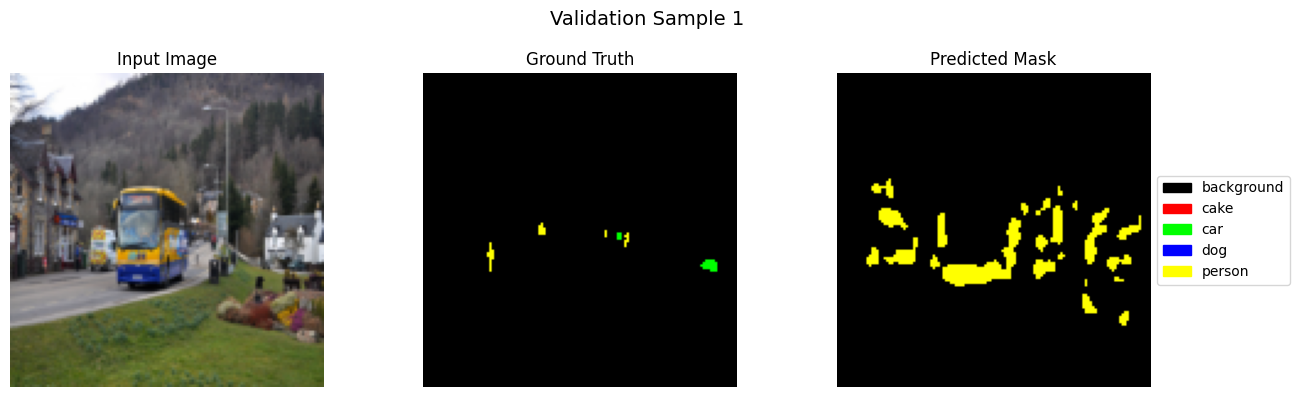


🖼️ Validation Sample 131:
Pixel-wise Accuracy: 0.9395
Class-wise IoU:
  background: 0.9388
  cake: N/A
  car: N/A
  dog: N/A
  person: 0.1644


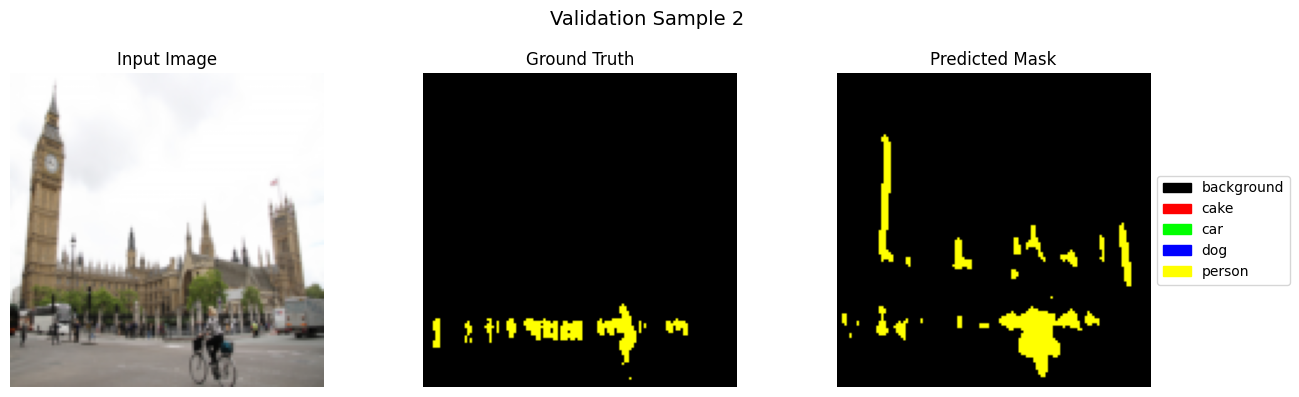


🖼️ Validation Sample 68:
Pixel-wise Accuracy: 0.7139
Class-wise IoU:
  background: 0.6758
  cake: N/A
  car: 0.0000
  dog: N/A
  person: 0.2933


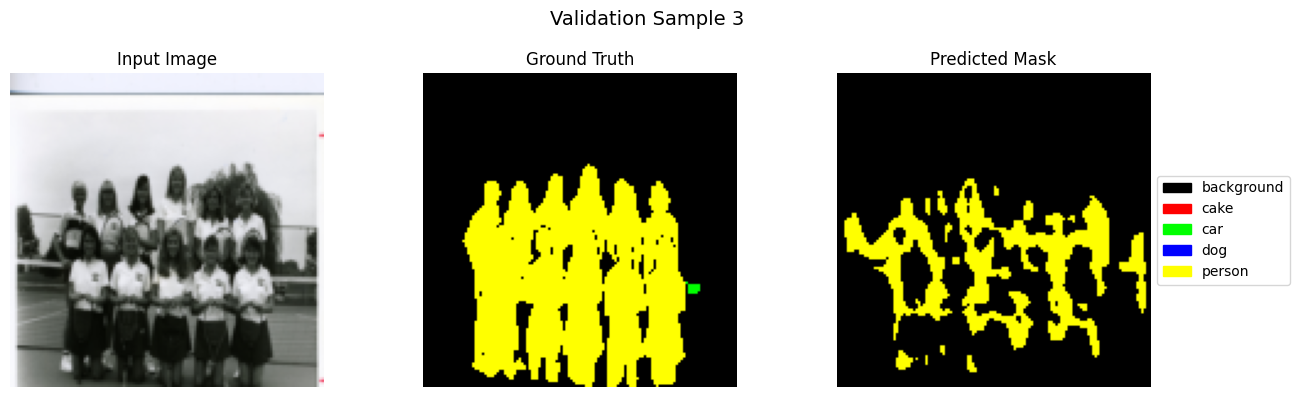

In [55]:
model.eval()
shown = 0
attempts = 0

while shown < 3 and attempts < 100:
    idx = random.randint(0, len(val_dataset) - 1)
    img, mask = val_dataset[idx]
    if mask.sum() > 50:
        with torch.no_grad():
            input_tensor = img.unsqueeze(0).to(device)
            output = model(input_tensor)

            acc = pixel_accuracy(output, mask.unsqueeze(0).to(device))
            iou = compute_iou(output, mask.unsqueeze(0).to(device))

            print(f"\n🖼️ Validation Sample {idx}:")
            print(f"Pixel-wise Accuracy: {acc:.4f}")
            print("Class-wise IoU:")
            for i, val in enumerate(iou):
                val_str = f"{val.item():.4f}" if not torch.isnan(val) else "N/A"
                print(f"  {class_names[i]}: {val_str}")

            visualize_prediction(img, mask, output[0], index=shown)
        shown += 1
    attempts += 1


## Visualize U-Net Predictions on Test Images

In [62]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class InferenceImageDataset(Dataset):
    def __init__(self, image_dir, image_size=(128, 128)):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(image_size)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, file_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, file_name

In [63]:
test_image_dir = "/content/drive/MyDrive/coco2017/test-30"  # no 'data/' folder needed

test_dataset = InferenceImageDataset(test_image_dir, image_size=(128, 128))


In [64]:
def apply_color_mask(mask):
    class_colors = {
        0: (0, 0, 0),        # background
        1: (255, 0, 0),      # cake
        2: (0, 255, 0),      # car
        3: (0, 0, 255),      # dog
        4: (255, 255, 0)     # person
    }
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask


/tmp/ipython-input-73-546099228.py:38: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


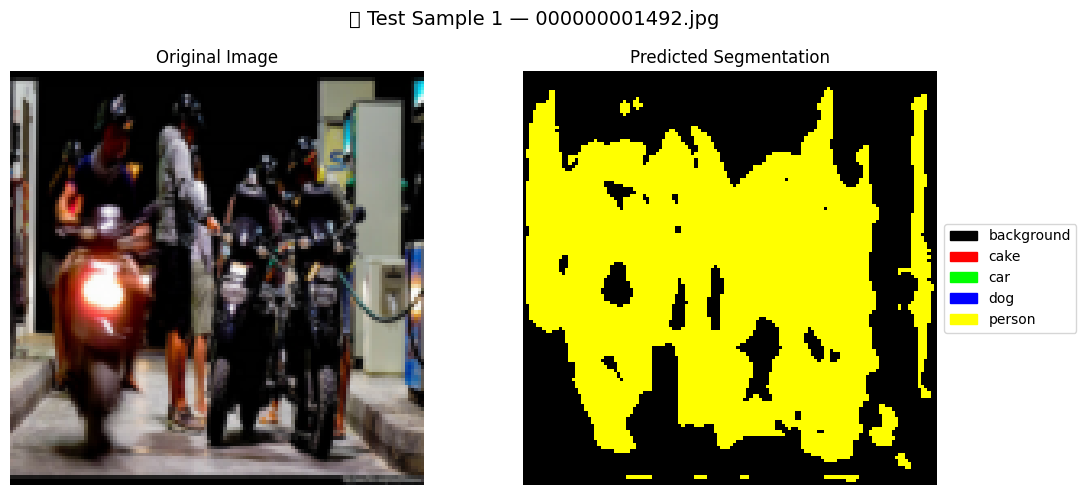

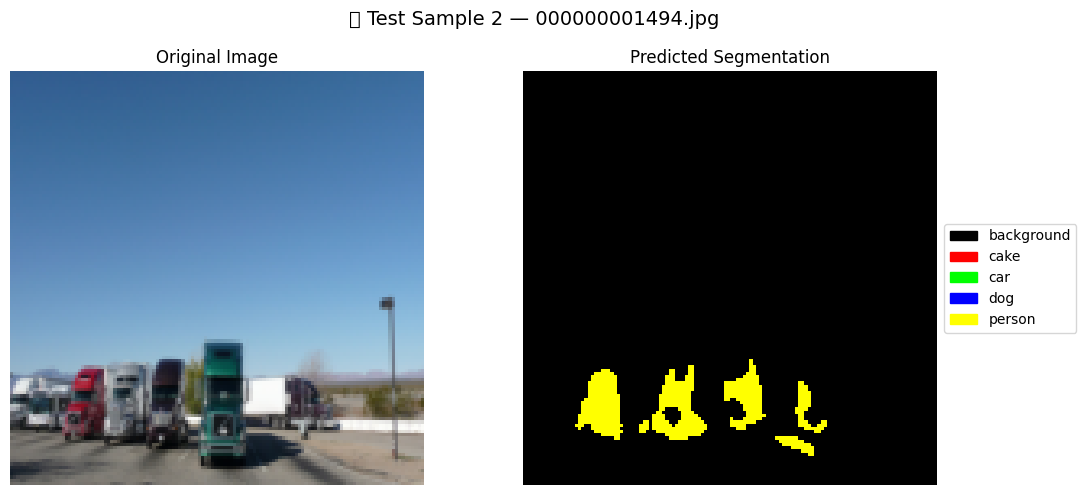

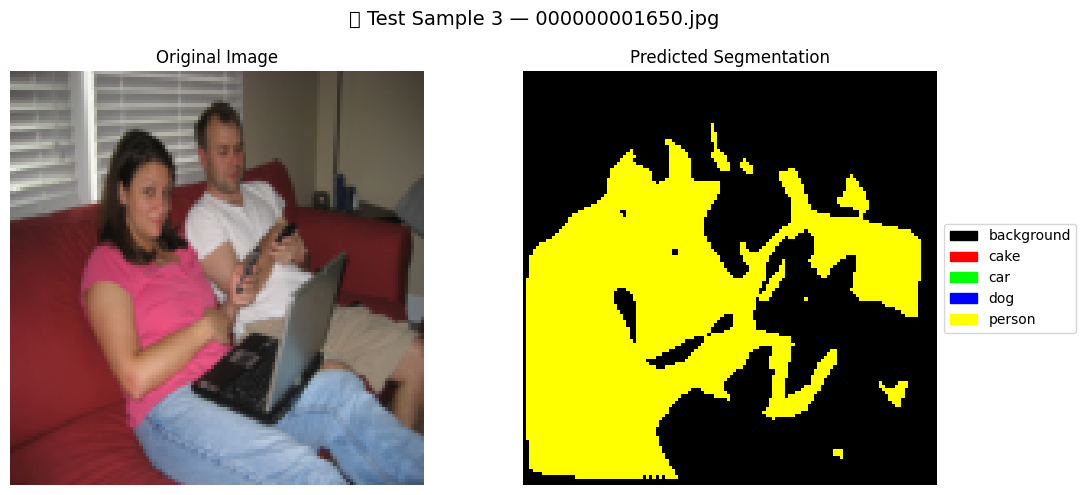

In [73]:
model.eval()
shown = 0
attempts = 0

while shown < 3 and attempts < 100:
    idx = random.randint(0, len(test_dataset) - 1)
    img, file_name = test_dataset[idx]

    with torch.no_grad():
        input_tensor = img.unsqueeze(0).to(device)
        output = model(input_tensor)
        pred = torch.argmax(output[0], dim=0).cpu().numpy()

    # Convert tensors to numpy for plotting
    original_img = img.permute(1, 2, 0).cpu().numpy()
    pred_color = apply_color_mask(pred)

    # Plot side-by-side
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"🖼️ Test Sample {shown+1} — {file_name}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_color)
    plt.title("Predicted Segmentation")
    plt.axis("off")

    # Optional legend
    legend_patches = [
        mpatches.Patch(color=np.array(color)/255.0, label=label)
        for label, color in zip(class_names, class_colors.values())
    ]
    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

    shown += 1
    attempts += 1
